In [3]:
from BPMQ_model import BPMQ_model

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import torch
_dtype = torch.float32

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor")

# load model

In [5]:
BPMs = ['BDS_BTS:BPM_D5513','BDS_BTS:BPM_D5565']

In [6]:
models = {}
history = {}
for bpm in BPMs:
    fname = bpm.replace('_D','')[-7:]
    state_dict = torch.load(fname+'/model.pt')
    model_info = {'n_node':len(state_dict['nn.2.bias']),
                  'n_hidden_layer':int((len(state_dict)-2)/2)-2,
                  'dtype':state_dict['nn.2.bias'].dtype}
    model = BPMQ_model(**model_info)
    model.load_state_dict(state_dict)
    models[bpm] = model

# load data

In [7]:
training_data = pickle.load(open('BDS_beamQ_training_data_from_ISAAC_filtered.pkl','rb'))

In [8]:
lrelpath = []
lmeas  = []
lsim   = []
lfmeas = []
lfsim  = []
for relpath, meas, sim in zip(training_data['rel_path'],training_data['measurement'],training_data['simulation']):
    if meas['BDS_BTS:BPM_D5513']['Q_err'].mean() > 1 or meas['BDS_BTS:BPM_D5565']['Q_err'].mean() > 1 :
        continue
    lrelpath.append(relpath)
    mask1 = meas.notna().all(axis=1)
    mask2 = sim.notna().all(axis=1)
    combined_mask = mask1 & mask2
    filtered_meas, filtered_sim = meas[combined_mask], sim[combined_mask]
    lmeas.append(meas)
    lsim.append(sim)
    lfmeas.append(filtered_meas)
    lfsim.append(filtered_sim)

meas = pd.concat(lmeas,axis=0,ignore_index=True)
sim  = pd.concat(lsim,axis=0,ignore_index=True) 
filtered_meas = pd.concat(lfmeas,axis=0,ignore_index=True)
filtered_sim  = pd.concat(lfsim,axis=0,ignore_index=True)

In [7]:
U = {}
X = {}
Y = {}
Q = {}
Qmeas = {}
np.random.seed(0)
p = np.random.permutation(np.arange(len(filtered_meas[bpm])))
for bpm in BPMs:
    U    [bpm] = torch.tensor(filtered_meas[bpm][['U1','U2','U3','U4']].values[p],dtype=_dtype)
    X    [bpm] = torch.tensor(filtered_meas[bpm]['XPOS'].values[p] ,dtype=_dtype)
    Y    [bpm] = torch.tensor(filtered_meas[bpm]['YPOS'].values[p] ,dtype=_dtype)
    Q    [bpm] = torch.tensor(filtered_sim [bpm]['beamQ'].values[p],dtype=_dtype)
    Qmeas[bpm] = torch.tensor(filtered_meas[bpm]['beamQ'].values[p],dtype=_dtype)

# model prediction vs simulated BPMQ

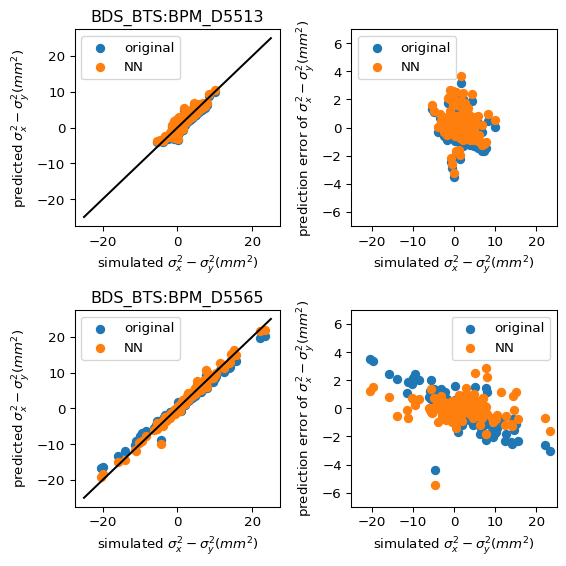

In [8]:
Qpred = {}
with torch.no_grad():
    for bpm in BPMs:
        model = models[bpm]
        Qpred[bpm] = model(U[bpm],X[bpm],Y[bpm]).view(-1).detach()
        
fig, ax = plt.subplots(2, 2, figsize=(6, 6),dpi=96)
for i, bpm in enumerate(BPMs):

    ax[i,0].scatter(Q[bpm], Qmeas[bpm],label='original')
    ax[i,0].scatter(Q[bpm], Qpred[bpm],label='NN')
    ax[i,0].plot([-25, 25], [-25, 25], color='k')
    ax[i,0].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,0].set_ylabel('predicted $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,0].legend()

    # Second subplot in the row
    ax[i,1].scatter(Q[bpm], Qmeas[bpm]-Q[bpm],label='original')
    ax[i,1].scatter(Q[bpm], Qpred[bpm]-Q[bpm],label='NN')
    ax[i,1].set_xlabel('simulated $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,1].set_ylabel('prediction error of $\sigma_x^2-\sigma_y^2 (mm^2)$')
    ax[i,1].set_xlim(-25,25)
    ax[i,1].set_ylim(-7, 7)
    ax[i,1].legend()
    
    # Set a single title for each row on the first subplot
    ax[i, 0].set_title(bpm)

plt.tight_layout()